# 0. Project introduction

<blockquote> 

In this project we will analyze how the investment in R&D (Research and Development) by private business has an impact on GDP (Gross Domestic Product) of the Organisation for Economic Co-operation and Development (OECD) countries. We will get data from the World Bank and OECD Databases.<br>

We will visualize how private business investment in R&D has changed before (2005-2006), during (2007-2008), after (2009-2010) and 5 years after (2015) the economic crisis of 2007-2008.<br>

Special attention will be paid on the periods before, during and after the economic crisis. We are specially interested to see if the investment made by private business in R&D in the previous years of the economic crisis (2005-2006) have a positive impact on the countries GDP during the economic crisis (2007-2008) or after (2009-2010). In this case, we will expect that the higher the investment of private business in the previous years of the economic crisis, the lesser the impact on the GDP. <br>

1. We will import the files, keep the relevant columns and clean the data.
2. Normality assumptions will be tested based on graphs and statistical significance.
3. In case of non-normal distribution of the data, we will apply the appropriate data transformation for statistical analyses.
4. Correlation analysis will show us the associations between private business investment in R&D and countries GDP.
5. Regression analysis will allow us to see if the country GDP could be predicted by private business investment in R&D.

</blockquote>

# 1. Set up

## 1.1. Environment

<blockquote> 

We will import basic packages to manage data, as well as to perform statistical analyses and to visualize data <br> <b>Statistical packages:</b> Numpy, ScipyStats, Pinguoin and StatsModels <br> <b>Visualization packages:</b> Matplotlib, Seaborn and Missingno to visualize missing values

</blockquote>

In [58]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt

## 1.2. Load data from previous notebook 

In [59]:
%store -r GDP_OECD
%store -r GERD_OECD
%store -r GDP_OECD_periods
%store -r GERD_OECD_periods
%store -r GERD_OECD_financed
%store -r GERD_OECD_performed

# 3. Transform data

## 3.1. Normality assumptions

### 3.1.1. Visualization

<blockquote>

Let's check if the distribution of the data is similar to a normal distribution and if a data transformation could improve the skewness of the data.

Based on the distribution and Q-Q plots, we can see that some data, especially data from the GERD dataframe show a positive skewness. To correct this skewness and adjust the data to a normal distribution we will apply a logaritmic transformation. However, as we have some missing values in the GERD_OECD_periods dataframe, we are going to drop NaN values for each dependent variable plotted. As numpy log can handle NaN values, we don't need to drop them before applying the numpy log transformation of the data, only before plotting each dependent variable.

</blockquote>

In [29]:
GDP_vars = ['GDPV_ANNPCT', 'GDP_ANNPCT', 'PGDP']
GERD_vars = ['GERD_financed_business_perc', 'GERD_performed_business_perc', 'GERD_performed_business_perc_GDP']

dfs_OECDcountries = {'GDP_OECD': GDP_OECD, 'GDP_OECD_periods': GDP_OECD_periods, 
                     'GERD_OECD': GERD_OECD, 'GERD_OECD_periods': GERD_OECD_periods}

def check_normality(dfs_dict, transf = None):
    
    """
    Plot dependent variables from the given dataframe
    to perform a visual check of the distribution.
    
    Input:
    dfs_dict: dictionary with dataframe name and df
    transf: transformation to apply using Numpy
    
    Output:
    Plots
    """
    
    for df_name, df in dfs_dict.items():
        if 'GDP' in df_name:
            vds = GDP_vars
        elif 'GERD' in df_name:
            vds = GERD_vars
    
        fig, ax = plt.subplots(2, len(vds), figsize = (20,10))

        # we just need the vds to be plotted
        df_plot = df[vds]
        
        if transf != None:
            df_plot = df_plot.apply(transf)
        else:
            df_plot = df_plot
        
        print('Plotting info for: ' + str(df_name))
        
        for i in range(len(vds)):
            # drop NaN values to plot for each vds
            sns.distplot(df_plot[vds[i]].dropna(), fit = norm, ax = ax[0, i])
            stats.probplot(df_plot[vds[i]].dropna(), plot = ax[1, i])

Plotting info for: GDP_OECD
Plotting info for: GDP_OECD_periods
Plotting info for: GERD_OECD
Plotting info for: GERD_OECD_periods


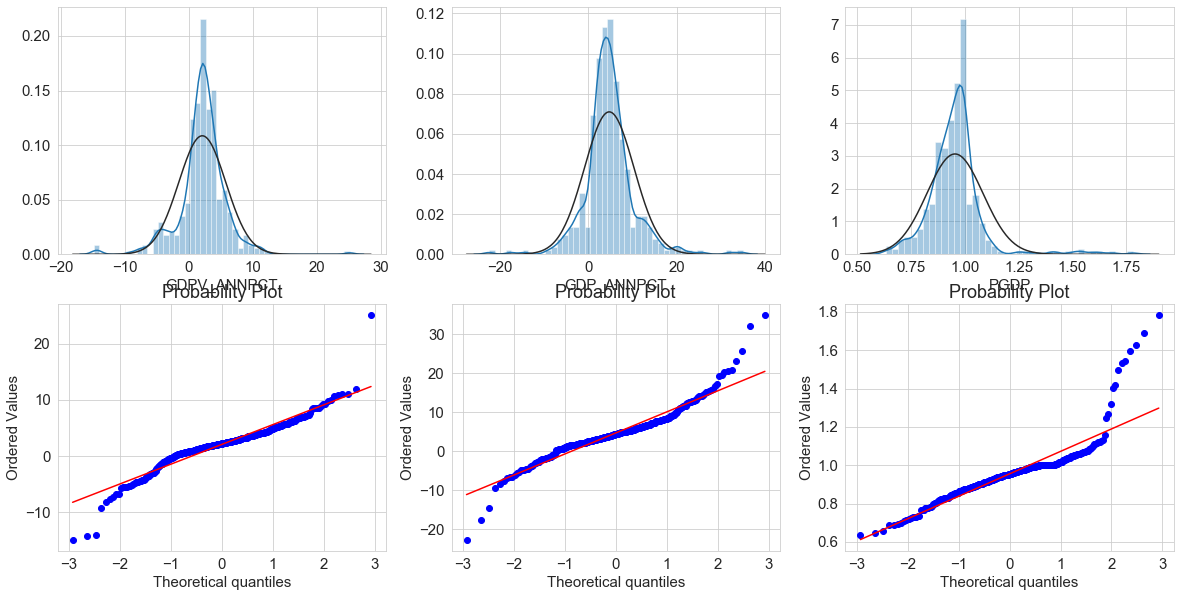

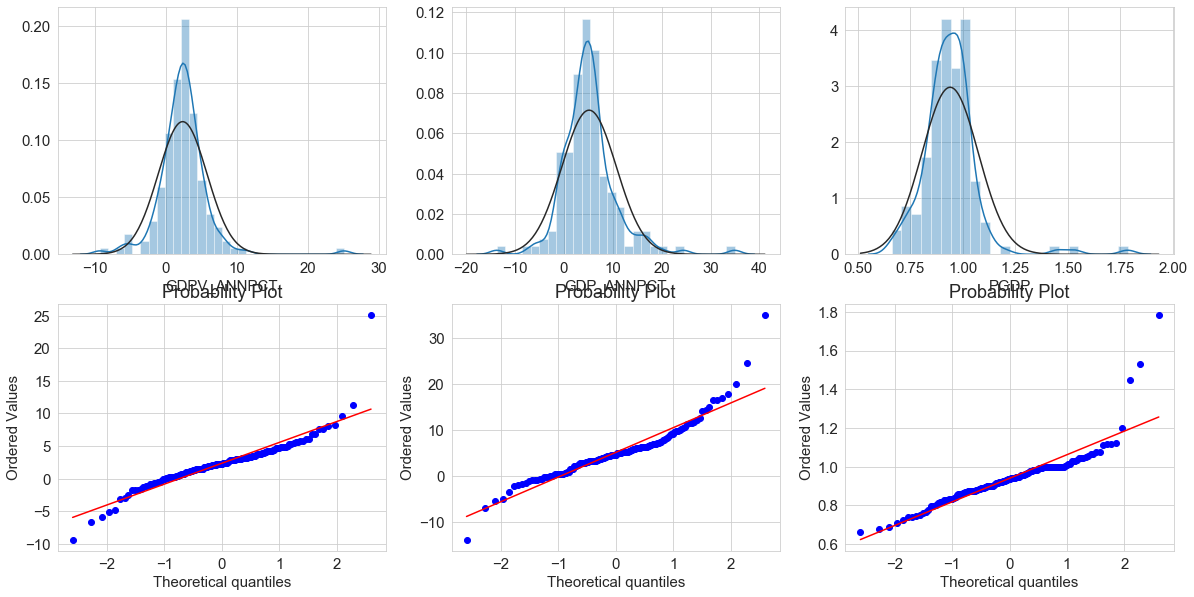

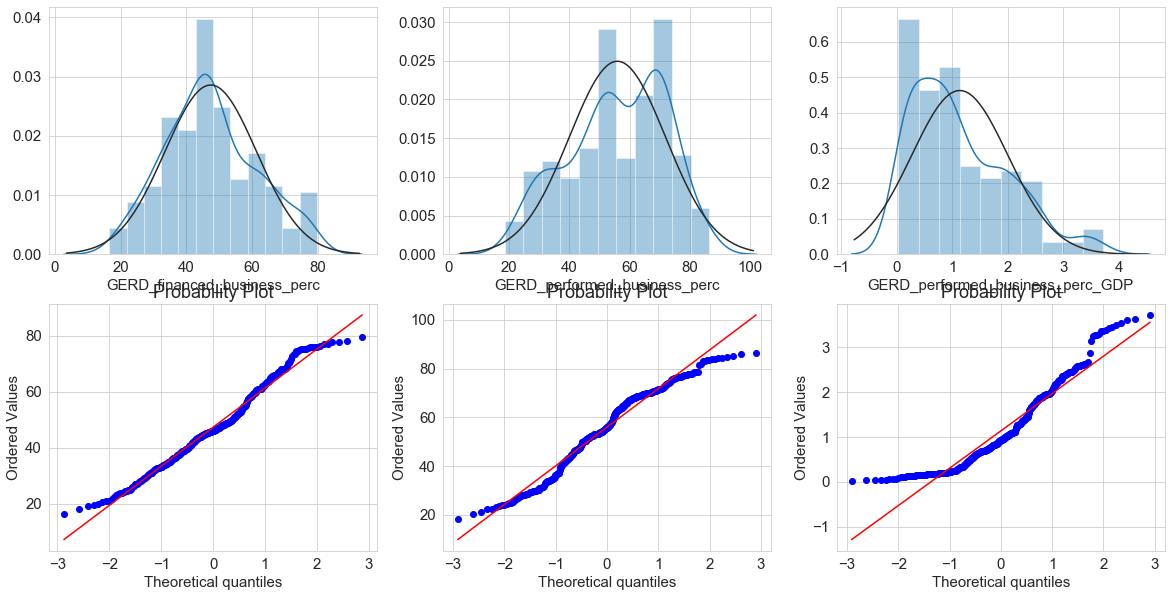

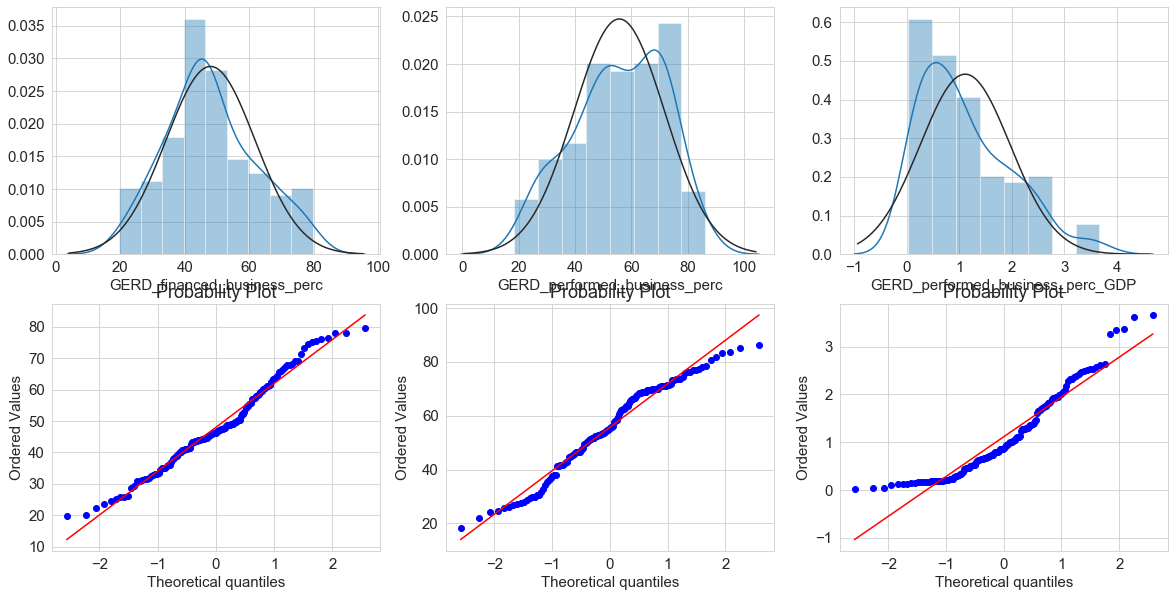

In [30]:
check_normality(dfs_OECDcountries)

### 3.1.1. Statistical tests

<blockquote>
    
Unless a visual inspection of the distribution is more desirable that rely on test, let's use this approach as it could be more objective. We will apply Kolmogorov-Smirnov, Shapiro-Wilk and D'Agostino-Pearson tests to the dependent variables in each dataframe.<br>

**Summary:** we can see from these test that the majority of the dependent variables are not normally distributed as the p-values are less than 0.05<br>

</blockquote>

In [477]:
def normalityCheck(df, vars_list):
    
    """
    Checks normality assumptions ussing K-S (Kolmogorov-Smirnov), 
    S-W (Shapiro-Wilk) and D-P (D'Agostino-Pearson).
    
    Input:
    df: DataFrame
    vars_list = list of dependent variabes to be tested
    
    Output:
    DataFrame with K-S, S-W and D-P statistics and p-values
    """
    
    normality_tests = {'K-S': stats.kstest, 'S-W': stats.shapiro, 'D-P': stats.normaltest}
    normality_dfs = []
    
    for test_name, test_module in normality_tests.items():
        
        if test_name == 'K-S':
            df_NormalityCheck = pd.DataFrame(dict([(dv, test_module(df[dv].dropna(), 'norm')) \
                                                   for dv in vars_list])).rename({0: test_name, 1: 'p-value'}).T
            normality_dfs.append(df_NormalityCheck)
        
        else:
            df_NormalityCheck = pd.DataFrame(dict([(dv, test_module(df[dv].dropna())) \
                                                   for dv in vars_list])).rename({0: test_name, 1: 'p-value'}).T
            normality_dfs.append(df_NormalityCheck)
    
    df_NormalityCheck = pd.concat(normality_dfs, axis = 1, sort = False).round(2)
    
    return df_NormalityCheck

In [478]:
# normality tests

for df_name, df in dfs_OECDcountries.items():
    
    if 'GDP' in df_name:
        vds = GDP_vars
    
    elif 'GERD' in df_name:
        vds = GERD_vars
    
    print('Displaying normality statistics for DataFrame: ' + df_name)
    
    display(normalityCheck(df, vds))

Displaying normality statistics for DataFrame: GDP_OECD


,K-S,p-value,S-W,p-value,D-P,p-value
GDPV_ANNPCT,0.59,0.0,0.91,0.0,66.46,0.0
GDP_ANNPCT,0.75,0.0,0.91,0.0,75.66,0.0
PGDP,0.75,0.0,0.80,0.0,235.03,0.0


Displaying normality statistics for DataFrame: GDP_OECD_periods


,K-S,p-value,S-W,p-value,D-P,p-value
GDPV_ANNPCT,0.60,0.0,0.86,0.0,81.06,0.0
GDP_ANNPCT,0.75,0.0,0.90,0.0,55.96,0.0
PGDP,0.75,0.0,0.81,0.0,104.70,0.0


Displaying normality statistics for DataFrame: GERD_OECD


,K-S,p-value,S-W,p-value,D-P,p-value
GERD_financed_business_perc,1.00,0.0,0.98,0.0,9.13,0.01
GERD_performed_business_perc,1.00,0.0,0.97,0.0,34.99,0.00
GERD_performed_business_perc_GDP,0.52,0.0,0.92,0.0,36.90,0.00


Displaying normality statistics for DataFrame: GERD_OECD_periods


,K-S,p-value,S-W,p-value,D-P,p-value
GERD_financed_business_perc,1.00,0.0,0.98,0.03,3.14,0.21
GERD_performed_business_perc,1.00,0.0,0.97,0.00,11.30,0.00
GERD_performed_business_perc_GDP,0.52,0.0,0.91,0.00,16.06,0.00


## 3.2. Data transformation

<blockquote>

Some data show a positive skewness. It seems that the log transformation adjust the data to be normally distributed. However, the problem with log transformation is that it can't handle negative values (returns NaN). We should avoid losing negative values, as in some cases most of the values in GDP data are negative.</br>

We have also performed the square root transformation, but this transformation doesn't normalize the distribution of the data, and it can't handle zero values. We find the same problem with cubic square root transformation, but in this case it could also exagerate outliers.</br>

Adding a constant could not act simmetrically, so it is possible that it doesn't normalize the distribution. In this case we will chose to add the minimum value plus 1 to every value in the distribution to make sure that the new minimum value is 1.</br>

Reciprocal transformations are another option available, however they can't be applied to zero values. Finally, Box-Cox transformations cannot handle negative values neither.</br>

Before applying transformation to the data that can modify the interpretation and non normalize the distribution we have non-parametric options to perform analysis that are more robust (Spearman rank correlation and quantile regression). We have performed linear regression to the data, however the residuals were not normally distributed.

</blockquote>

Plotting info for: GDP_OECD
Plotting info for: GDP_OECD_periods
Plotting info for: GERD_OECD
Plotting info for: GERD_OECD_periods


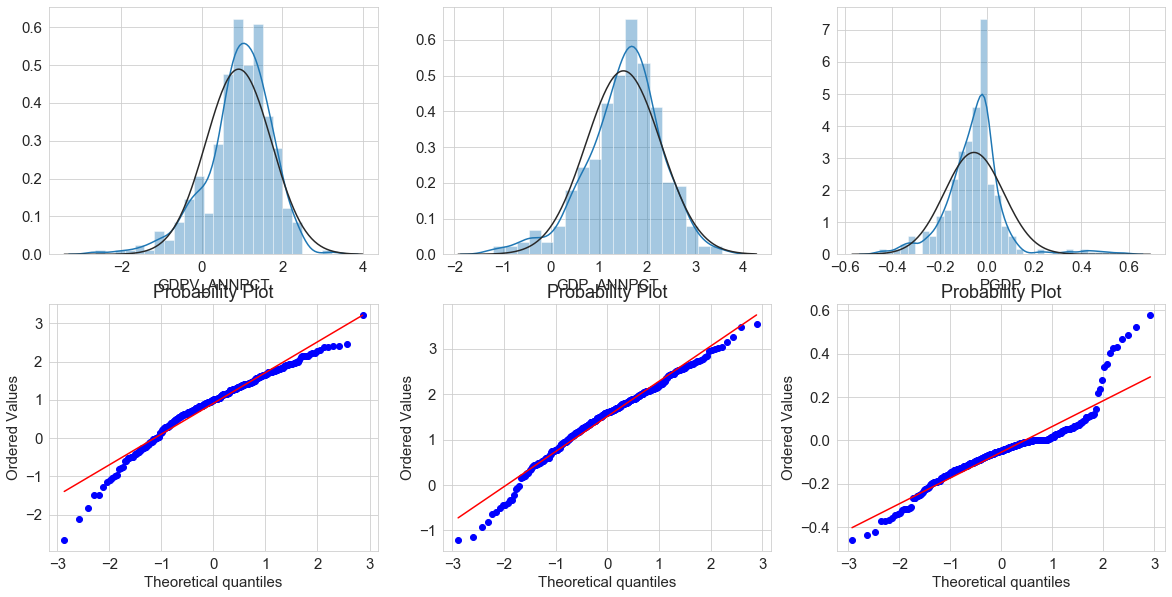

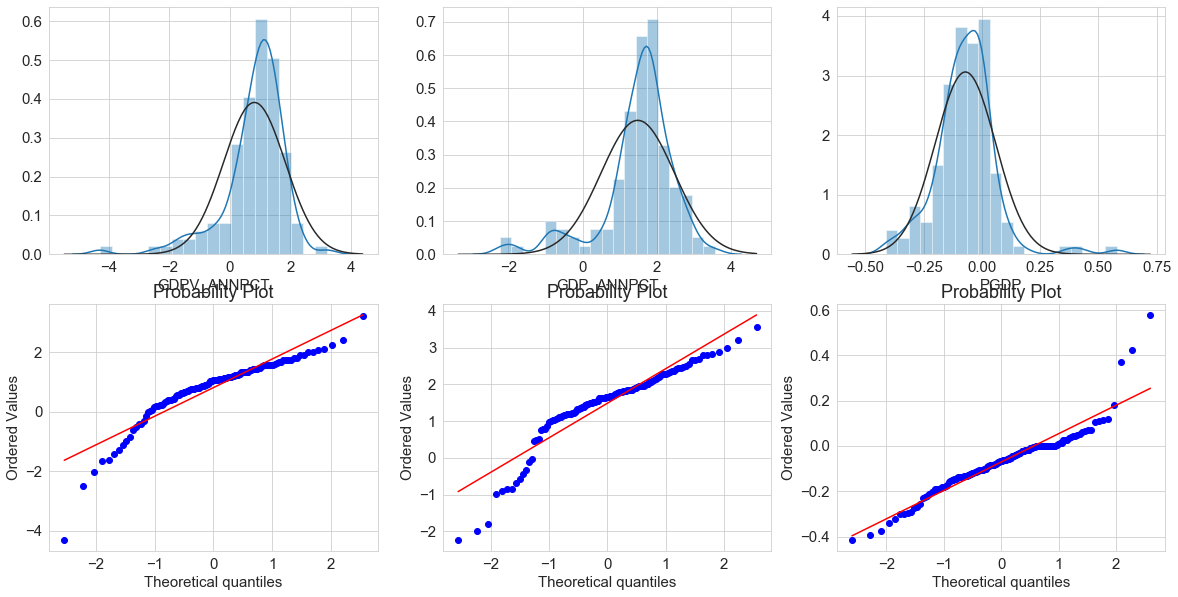

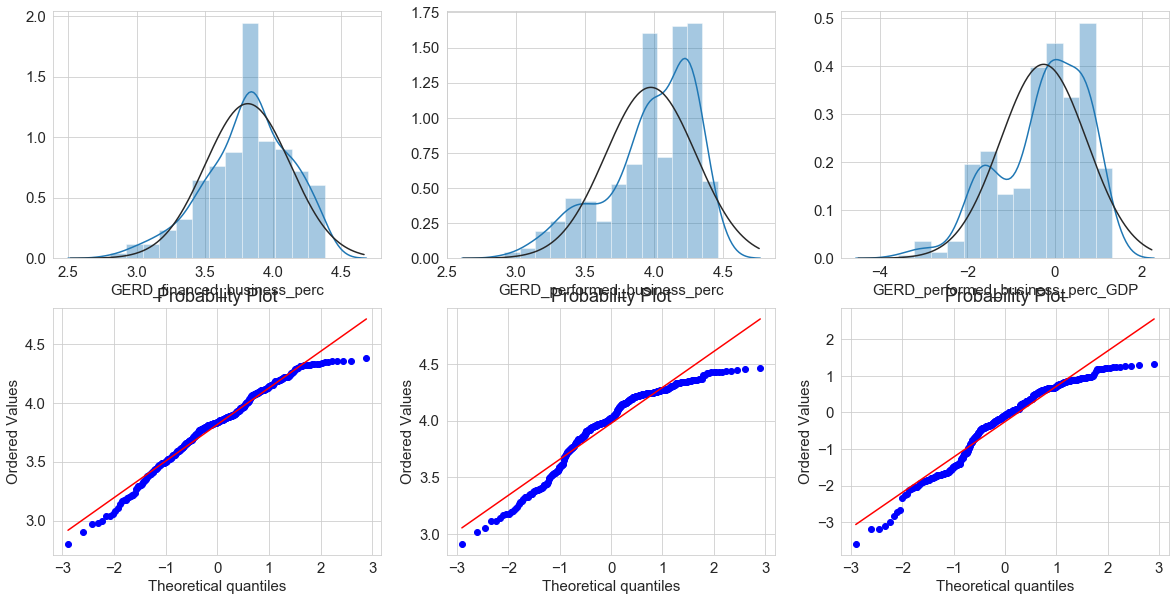

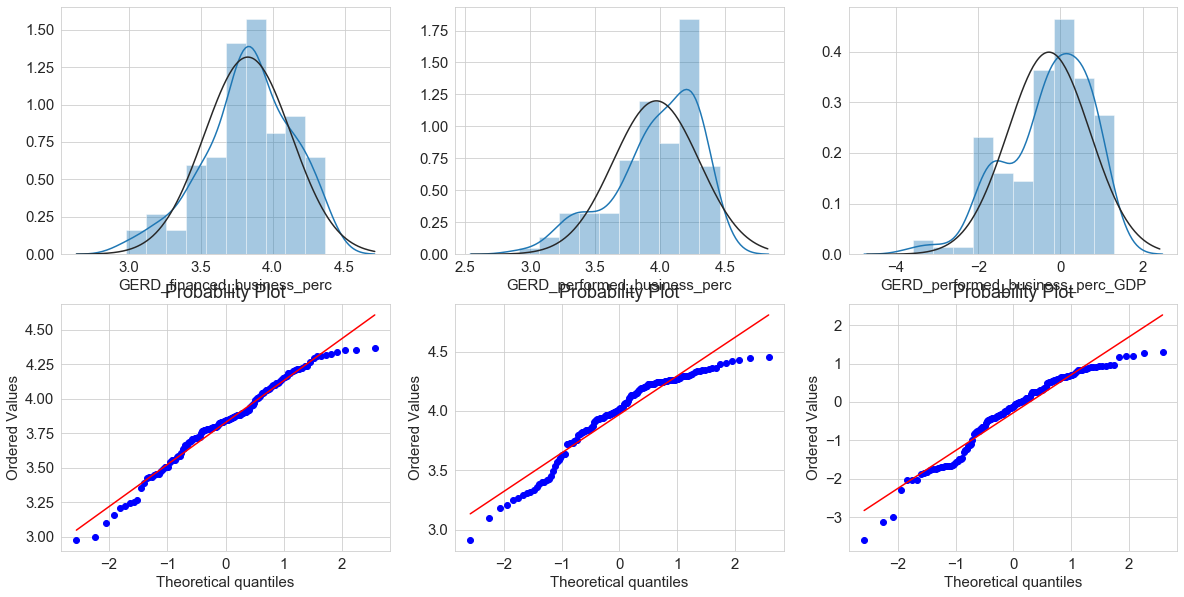

In [479]:
check_normality(dfs_OECDcountries, np.log)

In [480]:
# show number of rows with any negative value in the GDP DataFrame
GDP_negative = GDP_OECD[(GDP_OECD[GDP_vars] < 0).any(axis = 1)]
GDP_per_negative = GDP_OECD_periods[(GDP_OECD_periods[GDP_vars] < 0).any(axis = 1)]

display('Number of negative values in the GDP dataframe: ' + str(len(GDP_negative)) + 
        ', and number of negative values in the GDP periods dataframe: ' + str(len(GDP_per_negative)))

'Number of negative values in the GDP dataframe: 76, and number of negative values in the GDP periods dataframe: 27'